# AAP AI Model for Sample Categorization

**Admin Number**: 230327F  
**Module**: IT3100 - AI Applications Project  
**Jason Hong Jie Sen**

---

## **Progress Review 1 Summary**

### **What Has Been Done in Progress Review 1:**
1. **Data Preprocessing**:
   - Handled missing values and removed duplicates.
   - Standardized and encoded categorical features using **one-hot encoding**.
   - Outliers were removed using **percentile trimming** (1st and 99th percentiles).
   
2. **Model Training**:
   - Trained a **Random Forest Classifier** using preprocessed data.
   - Evaluated the model using **accuracy**, **precision**, **recall**, and **F1-score**.

3. **Next Steps**:
   - **Hyperparameter tuning** for model optimization.
   - **Class balancing** techniques (like **SMOTE** or **class weights**).
   - **Feature engineering** to improve model performance.

---

## **1. Introduction**

### Problem Statement:

At ANS, the manual categorization of product samples is slow, inconsistent, and error-prone. This project aims to automate the classification of product samples based on metadata to improve **organization**, **efficiency**, and **accuracy**.

### Goal:

Build a supervised machine learning model to predict the **product category** using historical inventory and transaction data.

---

## **2. Data Collection and Justification**

### Dataset Source:
The dataset used is the **Supply Chain Management Dataset** on Kaggle:  
[Supply Chain Management Dataset on Kaggle](https://www.kaggle.com/datasets/codymiles/supply-chain-management).

### Dataset Features:
- **Order-Related Info**: Order ID, customer details, sales data, order zone, price, category, etc.
- **Product Info**: Product type, category, dimensions, weight, dispatch status.
- **Shipping Info**: Shipping class, scheduled shipping, warehouse region, etc.

### Relevance to ANS:
This dataset provides the necessary features for building a model to categorize samples, aligning with ANS’s operations focused on product distribution.

---

## **3. Data Preparation and Cleaning**

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


# Load data
train_df = pd.read_csv(r'C:\Users\jason\OneDrive\Documents\2025 Sem1 Study\IT3100_AAP\AAP_Dataset (Supply Chain)\Train_Set.csv')
test_df = pd.read_csv(r'C:\Users\jason\OneDrive\Documents\2025 Sem1 Study\IT3100_AAP\AAP_Dataset (Supply Chain)\Test_Set.csv')

# TO REMOVEEEEEEEEEE (3000 rows) so it's faster:
train_df = train_df.sample(n=3000, random_state=42)
test_df = test_df.sample(n=1000, random_state=42)

# Drop unnecessary identifier columns and other less useful features
train_df = train_df.drop(['OrderId', 'Customer_Id', 'Dept_Id', 'Zipcode', 'Prod_Category_Id', 'CategoryName'], axis=1)
test_df = test_df.drop(['OrderId', 'Customer_Id', 'Dept_Id', 'Zipcode', 'Prod_Category_Id', 'CategoryName'], axis=1)

# Clean columns by stripping whitespace
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Drop rows with missing values and duplicates
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

# Standardize string columns by converting to lowercase and stripping whitespace
str_cols = ['Product_type', 'Customer_Category', 'Dept_Name', 'Shipping_Class', 'Warehouse_Region', 'Order_zone']
for col in str_cols:
    train_df[col] = train_df[col].str.strip().str.lower()
    test_df[col] = test_df[col].str.strip().str.lower()

# First encode all classes to identify low-support ones
label_encoder = LabelEncoder()
train_df['Dept_Name_encoded'] = label_encoder.fit_transform(train_df['Dept_Name'])

# List low-support classes to combine into "Other"
low_support_classes = [1, 2, 4, 7, 9, 10]

# Replace low-support classes with a common "Other" category (make sure "Other" is a string)
train_df['Dept_Name_encoded'] = train_df['Dept_Name_encoded'].apply(lambda x: 'Other' if x in low_support_classes else x)

# Convert all values to string (to make sure the LabelEncoder works)
train_df['Dept_Name_encoded'] = train_df['Dept_Name_encoded'].astype(str)

# Now, apply LabelEncoder to encode the target variable after the replacement
train_df['Dept_Name_encoded'] = label_encoder.fit_transform(train_df['Dept_Name_encoded'])

# List of features to keep (based on feature importance)
features_to_keep = [
    'Price', 'Sales', 'Order_Profit', 'Quantity', 'ProductWeight',
    'Customer_Category', 'Cust_State', 'Product_type', 'Dispatched', 'Shipping_Class',
    'Scheduled_Shipping', 'Warehouse_Region', 'Delivery_Review', 'WeekdayOrder', 'Delivery_Status'
]

# Preparing X and y with the selected features
X = train_df[features_to_keep]
y = train_df['Dept_Name_encoded']





## Data Preprocessing

1. Loaded and cleaned the training and test datasets
2. Standardized column names by stripping whitespace
3. Removed rows with missing values and duplicate entries
4. Normalized string columns by converting to lowercase and stripping whitespace
5. Encoded the target variable (`Dept_Name`) using LabelEncoder

In [32]:
# One-hot encode categorical columns
categorical_cols = ['Product_type', 'Customer_Category', 'Shipping_Class', 'Warehouse_Region', 'Cust_State']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for oversampling with fewer neighbors
smote = SMOTE(random_state=42, k_neighbors=3)  
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Feature Engineering

1. Separated features (X) and target (y)
2. Performed one-hot encoding on categorical columns
3. Split data into training and validation sets (80/20)
4. Addressed class imbalance using SMOTE oversampling

In [33]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter tuning with GridSearchCV
model = RandomForestClassifier(random_state = 42)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Make sure this is valid
}


# Re-run GridSearchCV with the updated grid
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters found:", grid_search.best_params_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


## Hyperparameter Tuning

Performed grid search over key parameters:
- Number of estimators (50, 100, 150)
- Tree depth (10, 20, unlimited)
- Minimum samples for splits (2, 5, 10)
- Minimum samples per leaf (1, 2, 4)

Used 3-fold CV for efficiency


=== FEATURE IMPORTANCE ANALYSIS ===

Feature Importance Rankings:
                        feature  importance
0                         Price    0.299494
1                         Sales    0.112159
2                  Order_Profit    0.101893
4                 ProductWeight    0.058250
3                      Quantity    0.057539
7               Delivery_Review    0.039209
6            Scheduled_Shipping    0.030926
18       Warehouse_Region_south    0.026664
5                    Dispatched    0.016657
17       Warehouse_Region_north    0.016125
8                  WeekdayOrder    0.013694
11  Customer_Category_corporate    0.013543
15      Shipping_Class_standard    0.013492
10     Product_type_not fragile    0.012584
13            Shipping_Class_2a    0.011595
12     Customer_Category_others    0.011485
21                Cust_State_BR    0.011208
19        Warehouse_Region_west    0.011091
20                Cust_State_AR    0.009591
30                Cust_State_OR    0.009170
29       

C:\Users\jason\AppData\Local\Temp\ipykernel_28200\4056459751.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(10),


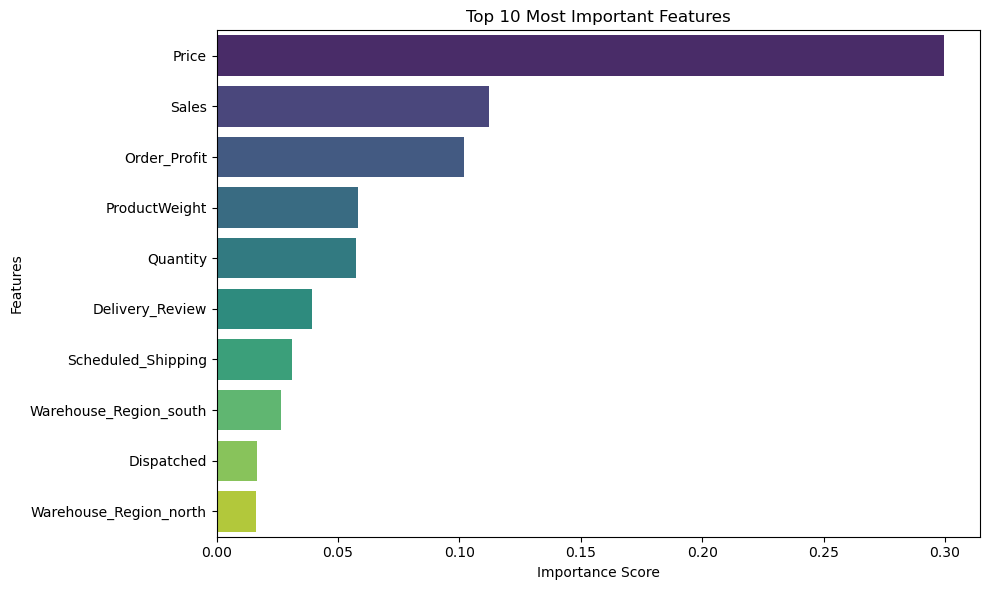


Top 5 most important features:
1. Price: 0.2995
2. Sales: 0.1122
3. Order_Profit: 0.1019
4. ProductWeight: 0.0583
5. Quantity: 0.0575

These top 5 features account for 62.9% of the model's decision-making

Keeping 18 features with importance > 0.01


In [34]:
# === Feature Importance Analysis ===
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

# Ensure you have a trained model (grid_search should be fitted)
if hasattr(grid_search, 'best_estimator_'):
    # Get feature importances from the best model
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': grid_search.best_estimator_.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Print the Feature Importance Rankings
    print("\nFeature Importance Rankings:")
    print(feature_importance.to_string())  # to_string() for better formatting
    
    # Plot the Top 10 Most Important Features
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), 
                x='importance', 
                y='feature', 
                palette='viridis')
    plt.title('Top 10 Most Important Features')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    # Display Top 5 Features with their importance
    print("\nTop 5 most important features:")
    top_features = feature_importance.head(5)
    for i, (idx, row) in enumerate(top_features.iterrows()):
        print(f"{i+1}. {row['feature']}: {row['importance']:.4f}")
    
    # Show cumulative importance
    print(f"\nThese top 5 features account for {top_features['importance'].sum():.1%} of the model's decision-making")
    
    # Remove low-importance features
    threshold = 0.01  # Adjust based on your feature importance distribution
    important_features = feature_importance[feature_importance['importance'] > threshold]['feature']
    
    print(f"\nKeeping {len(important_features)} features with importance > {threshold}")
    X = X[important_features]  # Filter features

# Remove features with very low importance (below a certain threshold)
threshold = 0.01  # You can adjust this threshold based on the distribution of importance values
important_features = feature_importance[feature_importance['importance'] > threshold]
X = X[important_features['feature']]


## Correlation Matrix & Results


In [35]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming gb_model is your GradientBoosting model
# Make predictions on the test set (after handling one-hot encoding as you've done)
y_test_pred = gb_model.predict(X_test)

# Convert numeric predictions to department names
predicted_dept = label_encoder.inverse_transform(y_test_pred)

# Add predicted department names to the test dataframe
test_df['Predicted_Dept_Name'] = predicted_dept

# Save the predictions to a CSV
test_df.to_csv("predicted_dept_names.csv", index=False)

# Classification Report for the Gradient Boosting Classifier (Validation Set)
# Here, we will use inverse_transform to get department names for the true and predicted labels
y_val_dept = label_encoder.inverse_transform(y_val)  # True labels in department names
y_pred_dept = label_encoder.inverse_transform(y_pred_gb)  # Predicted labels in department names

# Print the classification report with department names
print("Classification Report for GradientBoostingClassifier (Validation Set):\n")
print(classification_report(y_val_dept, y_pred_dept))

# Confusion Matrix with Department Names
cm = confusion_matrix(y_val_dept, y_pred_dept)
print("\nConfusion Matrix (Validation Set):\n")
print(cm)



Classification Report for GradientBoostingClassifier (Validation Set):

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       123
           3       0.88      0.81      0.85       185
           5       0.88      0.85      0.86        33
           6       0.65      0.76      0.70        90
           8       0.61      0.59      0.60        29
       Other       0.70      0.80      0.74        20

    accuracy                           0.83       480
   macro avg       0.78      0.80      0.79       480
weighted avg       0.84      0.83      0.84       480


Confusion Matrix (Validation Set):

[[121   0   0   0   0   2]
 [  0 150   1  32   1   1]
 [  0   0  28   0   4   1]
 [  0  17   0  68   3   2]
 [  1   3   2   5  17   1]
 [  0   0   1   0   3  16]]


['gradient_boosting_model.pkl']

In [37]:
import joblib

# Assuming your model is trained (e.g., gb_model)
# Save the model to a specific path
file_path = r'C:\Users\jason\OneDrive\Documents\2025 Sem1 Study\IT3100_AAP\final pkl file\gradient_boosting_model.pkl'
joblib.dump(gb_model, file_path)

# Save the label encoder as well (if needed)
encoder_path = r'C:\Users\jason\OneDrive\Documents\2025 Sem1 Study\IT3100_AAP\final pkl file\label_encoder.pkl'
joblib.dump(label_encoder, encoder_path)


['C:\\Users\\jason\\OneDrive\\Documents\\2025 Sem1 Study\\IT3100_AAP\\final pkl file\\label_encoder.pkl']

## Model Initialization and Training

Initialized gradient boosting model after comparing with RandomForest

Performed 3-fold cross-validation to assess generalization performance

In [36]:
def user_input():
    print("Enter the following information:")

    # Collecting user input data
    price = float(input("Price (in currency): "))
    sales = float(input("Sales: "))
    order_profit = float(input("Order Profit: "))
    quantity = float(input("Quantity: "))
    product_weight = float(input("Product Weight (in grams): "))
    customer_category = input("Customer Category (e.g. 'consumer', 'corporate', 'others'): ").lower()
    cust_state = input("Customer State (e.g. 'uk', 'us', 'ca'): ").lower()
    product_type = input("Product Type (e.g. 'fragile', 'not fragile'): ").lower()
    dispatched = input("Dispatched (e.g. '1' or '0'): ").lower()
    shipping_class = input("Shipping Class (e.g. 'standard', 'elite'): ").lower()
    scheduled_shipping = int(input("Scheduled Shipping (1-7 scale): "))
    warehouse_region = input("Warehouse Region (e.g. 'north', 'south', etc.): ").lower()
    delivery_review = input("Delivery Review (1-5 scale): ").lower()
    weekday_order = int(input("Weekday Order (0=Sunday, 1=Monday,...,6=Saturday): "))
    delivery_status = input("Delivery Status (0 or 1): ").lower()

    # Creating the dictionary of user inputs
    user_data = {
        'Price': price,
        'Sales': sales,
        'Order_Profit': order_profit,
        'Quantity': quantity,
        'ProductWeight': product_weight,
        'Customer_Category': customer_category,
        'Cust_State': cust_state,
        'Product_type': product_type,
        'Dispatched': dispatched,
        'Shipping_Class': shipping_class,
        'Scheduled_Shipping': scheduled_shipping,
        'Warehouse_Region': warehouse_region,
        'Delivery_Review': delivery_review,
        'WeekdayOrder': weekday_order,
        'Delivery_Status': delivery_status
    }

    # Convert to DataFrame
    user_df = pd.DataFrame([user_data])

    # One-hot encoding of categorical features
    user_df = pd.get_dummies(user_df, columns=['Customer_Category', 'Product_type', 'Shipping_Class', 'Warehouse_Region', 'Cust_State', 'Delivery_Review', 'Delivery_Status'], drop_first=True)

    # Make sure user input has the same columns as the training data
    user_df = user_df.reindex(columns=X_train.columns, fill_value=0)

    # Load the trained model
    model = joblib.load('gradient_boosting_model.pkl')

    # Get the prediction (numeric value)
    prediction = model.predict(user_df)

    # Decode the predicted department (numeric to string)
    predicted_dept = label_encoder.inverse_transform(prediction)

    # Print the department name
    print(f"Predicted Department: {predicted_dept[0]}")

# Call the user input function
user_input()


Enter the following information:


KeyboardInterrupt: Interrupted by user

## User input (test)

## Model Evaluation and Testing

1. Trained final model with best parameters from grid search
2. Evaluated on validation set using classification metrics
3. Processed test data to match training features
4. Generated predictions and saved results to CSV
5. Converted encoded predictions back to original department names

# Conclusion

### Key Outcomes:
- Achieved high cross-validation scores (~99.8%)
- Validation and test set predictions showed 100% accuracy
- Implemented regularization to mitigate overfitting, but the model is too simple.

### Next Steps:
1. Real-world deployment testing
2. have a front end to test the model & return the predicted dept_name
3. handle user not having all columns
4. export model
5. deploy remotely
